In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import unet2d

%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['nchannels'] = 1
params['channels'] = [0,1,2]
params['nepochs'] = [1]
params['batchsize'] = [512]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
sn = 16
params['enc_sizes'] = [[sn*1,3, 2], [sn*2, 3, 2],
                       [sn*4, 3, 2], [sn*8, 3, 2], [sn*16, 3, 2]]

params['dec_sizes'] = [[sn*8,3, 2], [sn*4, 3, 2],
                       [sn*2, 3, 2], [sn*1, 5, 2], [3, 3, 2]]
params['droprate'] = 0.1
params['stdev'] = 0.04

In [4]:
## read in the data
data_tif = imread('/scratch/cjw/Data/sez/NDExp.tif')
labels_tif = imread('/scratch/cjw/Data/sez/NDExp_labels.tif')
print(labels_tif.shape)

(9, 512, 512, 4)


(9, 512, 512, 4)


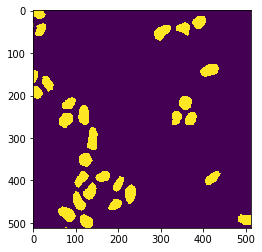

In [5]:
#labels_tif = labels_tif.max(axis=(-1), keepdims=True)
print(labels_tif.shape)
plt.imshow(labels_tif[0,:,:,0])
labels_tif.min(), labels_tif.max()

data_tif = data_tif[:,:,:,-1]
data_tif = np.expand_dims(data_tif, -1)

In [6]:

#normalize images 0-1
#try normalizing wit zero mean and equal sdev

dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
dmean = data_tif.mean(axis=(1,2),keepdims=True)
dstd = data_tif.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
data = (data_tif - dmean)/dstd
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())

#put cells with both channels into channel 0
labels = labels.max(axis=(-1), keepdims=True)

labshape = labels.shape
temp = np.zeros(labels.shape[0:3] + (2,), dtype=np.float32)
temp[:,:, :, 0:-1] = labels
tsum = labels.max() - labels.max(axis=(-1))
temp[:,:,:, -1] = tsum
labels = temp

data_tif.shape, data.shape, labels.shape, labels_tif.shape

((9, 512, 512, 1), (9, 512, 512, 1), (9, 512, 512, 2), (9, 512, 512, 4))

1.0 0.0


'1.12.0'

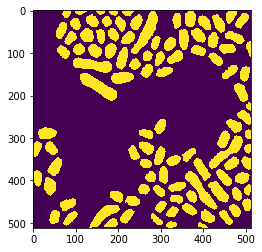

In [7]:

print(labels.max(), labels.min())

plt.imshow(labels[-1,:,:,0])
tf.__version__

((9, 512, 512, 3), (9, 512, 512, 1))

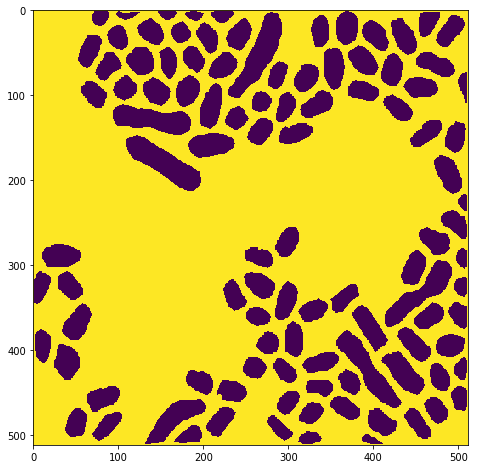

In [8]:

def get_outline(a, ch):
    
    b = a[:,:,ch] 
    b[np.where(b > 0)] = 1
    
    e0 = distance_transform_edt(b)
    ew = np.where(np.logical_and(e0 >= 1, e0 <=2))
    ew0 = np.zeros(b.shape, dtype=a.dtype)
    ew0[ew] = 1
    return ew0, ew

z = labels.copy()

ch4= np.zeros((labels.shape[0:-1] + (labshape[-1],)), dtype=np.float32)

for i in range(labels.shape[0]):
    ch = 0
    q0, qw0 = get_outline(labels[i], ch)
    z[i,:,:,0][qw0] = 0
    
    ch4[i,:,:,0] = q0
#     ch4[i,:,:,2] = q2
#     ch4[i,:,:,3] = q3

plt.figure(figsize=(8,8))
z = np.concatenate([z, ch4], axis=-1)
labels = z

plt.imshow(labels[-1,:,:,-2]) # + .5*labels[-1,:,:,4] + .25*labels[-1,:,:,-1])
labels.shape, labshape

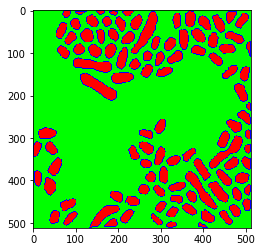

In [9]:
nv = -1
sh = [0,1,2]
pd = np.zeros((512, 512, 3), dtype=np.float32)
pd[:,:,0] = labels[nv, :,:,sh[0]]
pd[:,:,1] = labels[nv, :,:,sh[1]]
pd[:,:,2] = labels[nv ,:,:,sh[2]]
plt.imshow(pd)

In [10]:

tf.reset_default_graph()
u = unet2d.unet2d(params)
u.x = data
u.y = labels

In [11]:
test_images = imread('/scratch/cjw/Data/sez/test.tif')
tmean = test_images.mean(axis=(1,2),keepdims=True)
tstd = test_images.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
test_images = (test_images - tmean)/tstd
u.xtest = np.expand_dims(test_images[:,:,:,-1], -1)
print(test_images.std(axis=(1,2)))
u.xtest.shape, u.xtest.mean(axis=(1,2)).shape,u.xtest.mean(axis=(1,2)), u.xtest.min(axis=(1,2)), u.xtest.max(axis=(1,2))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


((4, 512, 512, 1), (4, 1), array([[-1.47451495e-17],
        [ 1.73472348e-18],
        [-2.94902991e-17],
        [ 1.73472348e-17]]), array([[-5.75321835],
        [-5.15309134],
        [-4.75164339],
        [-4.44155761]]), array([[7.96252817],
        [6.62614886],
        [6.74214584],
        [6.89048635]]))

In [12]:
w = 256

In [13]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, w, w, 1))
masks = tf.placeholder(tf.float32, (None, w, w, labels.shape[-1]))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [14]:
enc = u.create_encoder(images, True)

[8, 5, 2] <class 'int'>
[16, 3, 2] <class 'int'>
[32, 3, 2] <class 'int'>
[64, 3, 2] <class 'int'>
[128, 3, 2] <class 'int'>


In [15]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

Tensor("decoder-layer-64/BiasAdd:0", shape=(?, 16, 16, 64), dtype=float32)
4 Tensor("Relu_7:0", shape=(?, 16, 16, 64), dtype=float32)
after concat Tensor("concat-64:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("Relu_8:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("decoder-layer-32/BiasAdd:0", shape=(?, 32, 32, 32), dtype=float32)
3 Tensor("Relu_5:0", shape=(?, 32, 32, 32), dtype=float32)
after concat Tensor("concat-32:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("Relu_9:0", shape=(?, 32, 32, 32), dtype=float32)
Tensor("decoder-layer-16/BiasAdd:0", shape=(?, 64, 64, 16), dtype=float32)
2 Tensor("Relu_3:0", shape=(?, 64, 64, 16), dtype=float32)
after concat Tensor("concat-16:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("Relu_10:0", shape=(?, 64, 64, 16), dtype=float32)
Tensor("decoder-layer-8/BiasAdd:0", shape=(?, 128, 128, 8), dtype=float32)
1 Tensor("Relu_1:0", shape=(?, 128, 128, 8), dtype=float32)
after concat Tensor("concat-8:0", shape=(?, 128, 128, 16), dtype=float3

In [16]:
#u.set_validation(20)
u.xtrain = u.x

In [17]:
sess = tf.Session()

In [18]:
# tf.summary.scalar('loss', u.loss)
# si = tf.slice(u.decoder, [5, 0, 0, 0, 0], [10,1,256,256, 1])

# si = si[:,:,:,:,0]
# print(si)
# tf.summary.image('res', si, max_outputs=1)    
# merged = tf.summary.merge_all()



# logdir = "logdir"
# logwriter = tf.summary.FileWriter(logdir, sess.graph)

In [19]:
sess.run(tf.global_variables_initializer())

(2, 256, 256, 1) (2, 256, 256, 3)


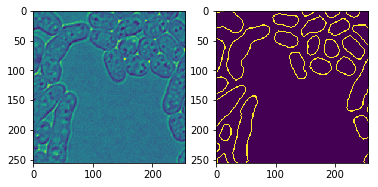

In [20]:
tb, tm = u.get_batch(2, erode=0)
tb = (tb - tb.min())/(tb.max() - tb.min())
print(tb.shape, tm.shape)
plt.subplot(1,2,1)
plt.imshow(tb[1,:,:,0])
plt.subplot(1,2,2)
plt.imshow(tm[-1,:,:,-1])

(256, 256, 3)


(256, 256)

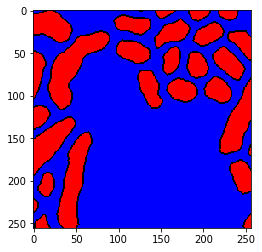

In [21]:
bz = tm[1]
print(bz.shape)
bz[:,:,-2] = 0

bzm = bz.max(axis=-1)
bz[:,:,-1] = 1 - bzm
plt.imshow(bz[:,:,-3:])
bzm.shape

In [22]:
u.stdev = 0.01
#u.learning_rate = 0.0001


0 1.1585574 1.1585574 0.0021456166 0.9591068 0.0009994
3


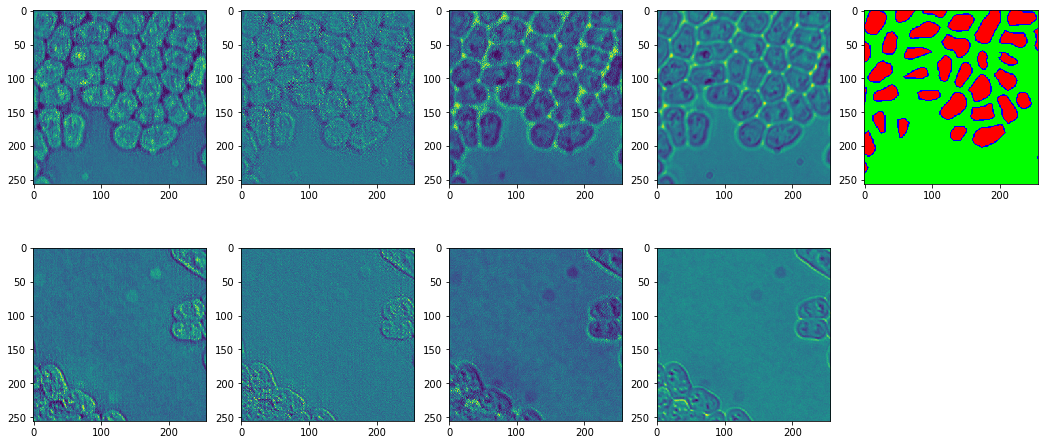

0 1.1585574 7.412111520767212 0.0009994
10 0.855742 0.5900669097900391 0.0009934197644027314
20 0.8284576 0.6282558441162109 0.000987475313494075
30 0.7799155 0.7234668731689453 0.0009815664331446845
40 0.6774478 0.72165846824646 0.0009756929105065258
50 0.67306834 1.3135545253753662 0.0009698545340052114
60 0.6442547 0.7782471179962158 0.0009640510933323775
70 0.6054309 0.6851365566253662 0.0009582823794381092
80 0.57474196 0.7421901226043701 0.0009525481845234097
90 0.5291994 0.8609042167663574 0.0009468483020327152
100 0.5437298 0.5437298 5.3749284e-07 0.99984956 0.0009411825266464541
1


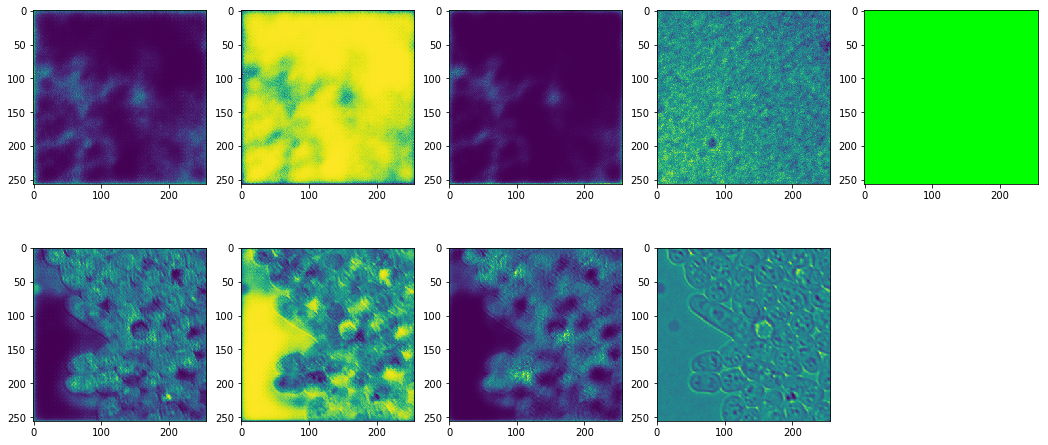

100 0.5437298 1.717576026916504 0.0009411825266464541
110 0.51938176 0.8783509731292725 0.0009355506542736522
120 0.52769536 0.7384684085845947 0.0009299524820445797
130 0.48904747 0.9472942352294922 0.0009243878083034437
140 0.4737683 0.9610273838043213 0.0009188564326011252
150 0.5077481 0.8761067390441895 0.0009133581556879571
160 0.47157803 1.0758624076843262 0.0009078927795065476
170 0.4644688 1.1881613731384277 0.0009024601071846466
180 0.43738008 0.8874368667602539 0.0008970599430280523
190 0.45497686 0.7705976963043213 0.0008916920925135638
200 0.45472896 0.45472896 1.9168496e-10 1.0 0.0008863563622819725
1


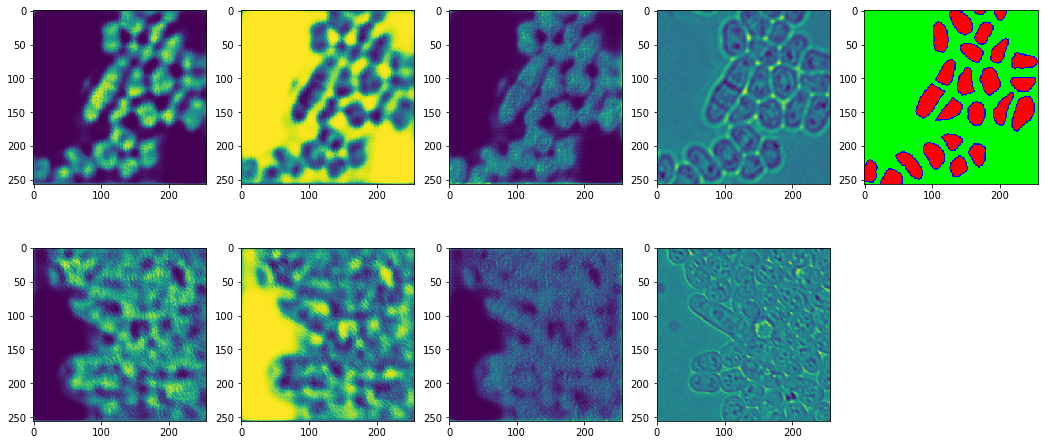

200 0.45472896 1.9892857074737549 0.0008863563622819725
210 0.43485597 0.9513001441955566 0.0008810525601310981
220 0.43523595 0.8479502201080322 0.0008757804950088642
230 0.47717908 1.2637274265289307 0.0008705399770064175
240 0.43221518 0.9401321411132812 0.0008653308173512857
250 0.44139603 1.390669822692871 0.0008601528284005777
260 0.37085152 0.808246374130249 0.0008550058236342256
270 0.4193561 0.8816218376159668 0.000849889617648265
280 0.47476906 0.923363447189331 0.0008448040261481561
290 0.4190203 1.0835912227630615 0.0008397488659421457
300 0.41923645 0.41923645 3.9209745e-08 0.9999999 0.0008347239549346682
6


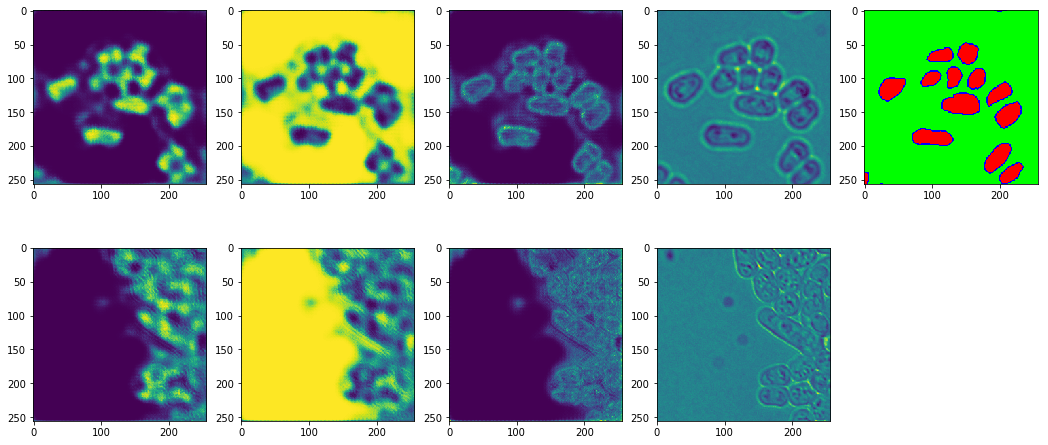

300 0.41923645 1.4793879985809326 0.0008347239549346682
310 0.39852938 1.1226122379302979 0.0008297291121197865
320 0.41076437 0.9649460315704346 0.0008247641575746708
330 0.39578325 0.9746294021606445 0.0008198289124531189
340 0.36971372 0.8568456172943115 0.0008149231989791124
350 0.397711 1.2128987312316895 0.0008100468404404146
360 0.38232225 1.232412338256836 0.0008051996611822031
370 0.38990438 0.864647388458252 0.0008003814866007439
380 0.40130267 1.2356455326080322 0.0007955921431371015
390 0.4067732 0.8389096260070801 0.0007908314582708864
400 0.38541237 0.38541237 1.0247434e-12 1.0 0.000786099260514041
13


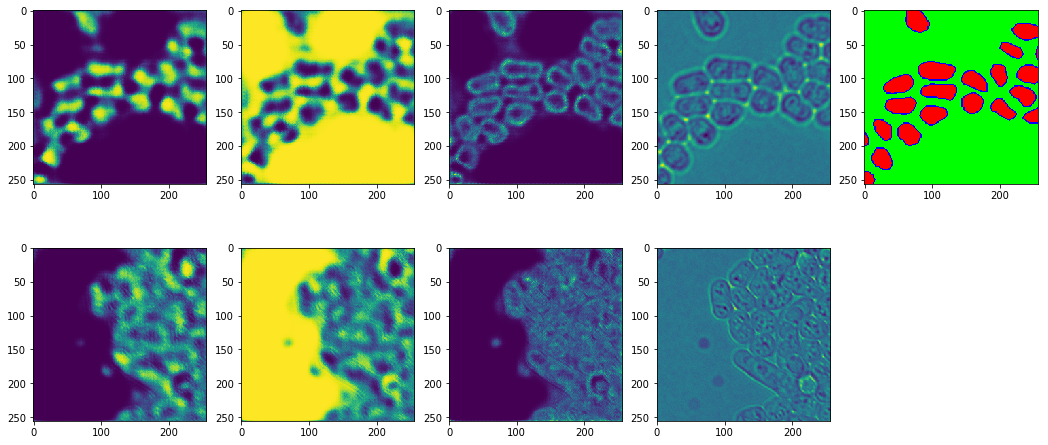

400 0.38541237 1.9703059196472168 0.000786099260514041
410 0.362181 1.8324189186096191 0.0007813953794046629
420 0.38432175 1.2365615367889404 0.0007767196455008638
430 0.38753122 0.9457426071166992 0.0007720718903746664
440 0.3862553 1.3616995811462402 0.0007674519466059365
450 0.39719975 0.9595355987548828 0.0007628596477763529
460 0.37182945 1.016183614730835 0.0007582948284634136
470 0.40893432 1.477773904800415 0.0007537573242344746
480 0.37392184 1.1672768592834473 0.0007492469716408296
490 0.40251628 0.8983094692230225 0.0007447636082118204
500 0.37462252 0.37462252 6.534902e-07 0.99999607 0.0007403070724489843
9


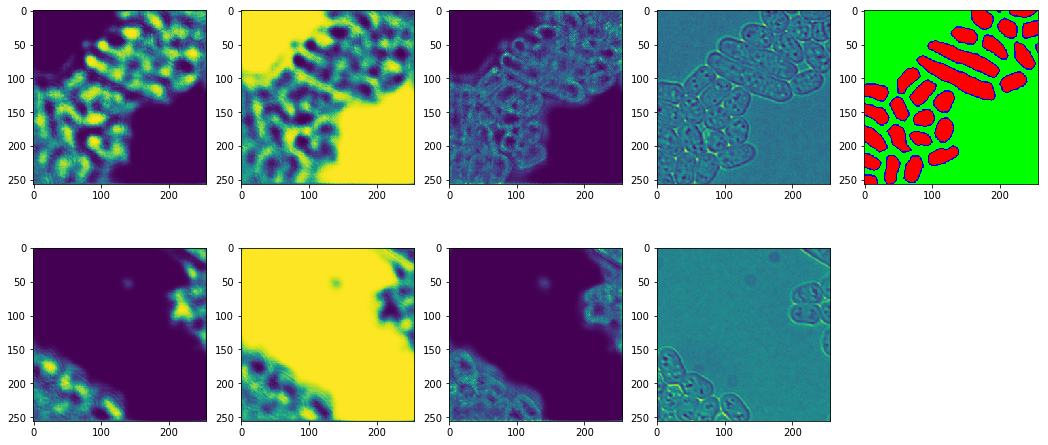

500 0.37462252 1.8276653289794922 0.0007403070724489843
510 0.3752002 1.2229537963867188 0.0007358772038202383
520 0.3631564 1.0555803775787354 0.0007314738427540945
530 0.36488682 0.9071371555328369 0.0007270968306339136
540 0.3869176 0.9357388019561768 0.0007227460097921905
550 0.3864804 1.0645751953125 0.0007184212235048752
560 0.40459546 0.8356969356536865 0.0007141223159857265
570 0.34243 0.8272304534912109 0.0007098491323807021
580 0.34510046 1.0201239585876465 0.0007056015187623779
590 0.38180715 1.1499342918395996 0.0007013793221244058
600 0.39503145 0.39503145 5.452734e-38 1.0 0.0006971823903760004
7


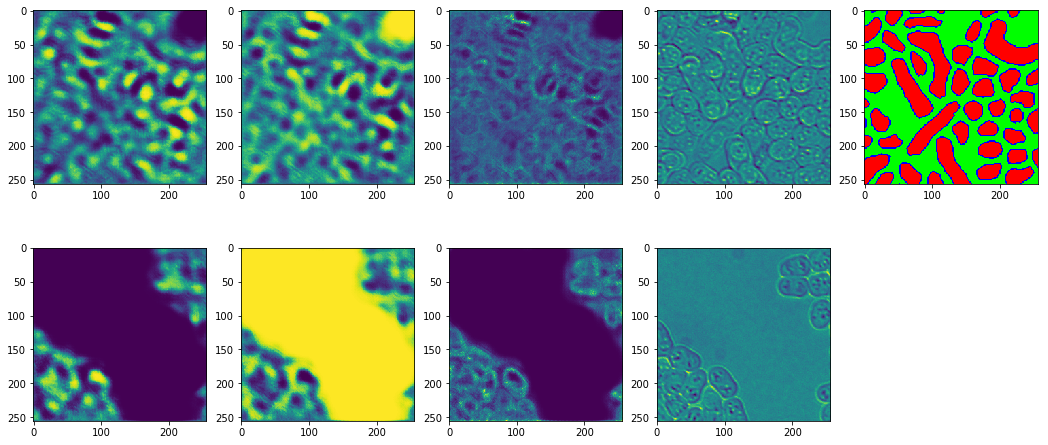

600 0.39503145 1.9882609844207764 0.0006971823903760004
610 0.39317942 0.811267614364624 0.0006930105723364615
620 0.35186547 1.3369660377502441 0.0006888637177297275
630 0.3780152 0.9460611343383789 0.0006847416771789632
640 0.3669783 1.179114818572998 0.0006806443022011777
650 0.35878074 1.1686210632324219 0.0006765714452018768
660 0.3507989 0.9123573303222656 0.000672522959469746
670 0.38955754 1.1088919639587402 0.0006684986991713657
680 0.3638714 1.264192819595337 0.0006644985193459582
690 0.37503633 1.2771060466766357 0.000660522275900166
700 0.36219123 0.36219123 3.0554507e-17 1.0 0.0006565698256028606
10


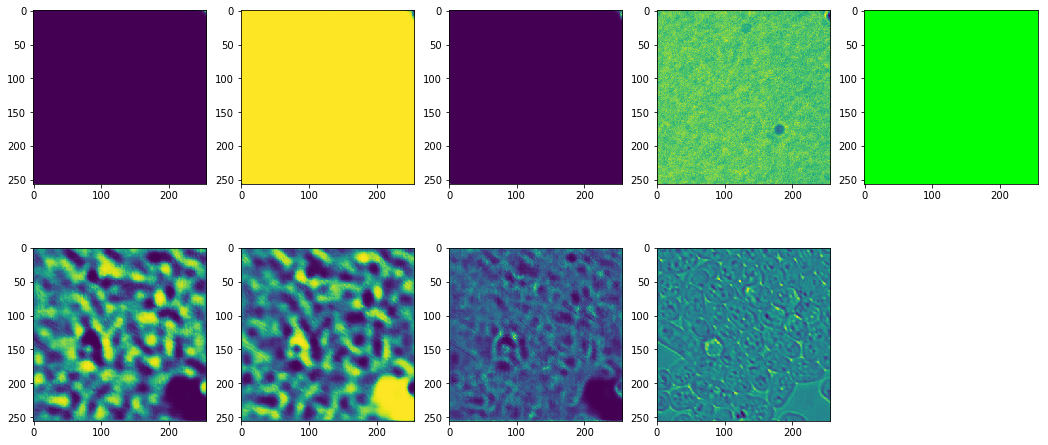

700 0.36219123 1.7127647399902344 0.0006565698256028606
710 0.38376242 0.7721071243286133 0.0006526410260799844


KeyboardInterrupt: 

In [23]:

rate = 0.001
#loss_file = open('progress.dat', 'w', buffering=1)

tbx, _ = u.get_batch(16, test=True, erode=0)
for i in range(2500):
    t1 = time.time()
    rate = np.maximum(rate*.9994, 0.000005)
    bx, bm = u.get_batch(256, erode=0)

#     plt.figure(figsize=(2,2))
#     plt.imshow(bm[0])
    _, res, err = sess.run([u.opt, u.decoder_softmax, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        print(i, err, err, res[0,:,:,:].min(), res[0,:,:,:].max(), rate)
        nr = np.random.randint(0,16)
        #nr = np.argmin(res[:,:,:,4].sum(axis=(1,2)))
        print(nr)
        
        tres = sess.run(u.decoder_softmax,
                           feed_dict={images:tbx, learning_rate:rate})
        
        plt.figure(figsize=(18,8))
        plt.subplot(2,5,1)
        plt.imshow(res[nr,:,:,0])
        plt.subplot(2,5,2)
        plt.imshow(res[nr,:,:,1])
        plt.subplot(2,5,3)
        plt.imshow(res[nr,:,:,2])
        plt.subplot(2,5,4)
        bxd = bx[nr,:,:,0]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        plt.subplot(2,5,5)
        plt.imshow(bm[nr,:,:,:])
        
        plt.subplot(2,5,6)
        plt.imshow(tres[nr,:,:,0])
        plt.subplot(2,5,7)
        plt.imshow(tres[nr,:,:,1])
        plt.subplot(2,5,8)
        plt.imshow(tres[nr,:,:,2])
        plt.subplot(2,5,9)
        bxd = tbx[nr,:,:,0]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        

        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
    if i % 10 == 0:
        print(i, err, (t2 - t1), rate)


In [ ]:
na = 13
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
print(bm.shape)
plt.imshow(res[na,:,:,0:3])
plt.subplot(1,3,2)
plt.imshow(bm[na,:,:,0:3])
plt.subplot(1,3,3)
plt.imshow(bx[na,:,:,:])


In [ ]:
plt.hist(res[na,:,:,:].reshape((-1,3)))

In [ ]:
#test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/16_hours_punched_overnight/NDExp_Point0008_Seq0008.tif')
test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0007_Seq0007.tif')
#test_tif = labels[-1,:,:,:] #imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0021_Seq0021.tif')
ymax = test_tif.max(axis=(0,1), keepdims=True)
ymin = test_tif.min(axis=(0,1), keepdims=True)
ymean = test_tif.mean(axis=(0,1), keepdims=True)
ystd = test_tif.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
test_tif = (test_tif - ymean)/ystd
test_tif.shape, ymin.shape

In [ ]:
plt.imshow(test_tif)

In [ ]:
def make_batch(data, start = 0):
    tclist = list()
    print(start)
    ix = start
    jy = start
    for i in range(6):
        jy = start
        for j in range(6):
            p = data[jy:jy + 256, ix:ix + 256,:]
            p = np.expand_dims(p, 0)
            tclist.append(p)
            jy = jy + 256
            #print(i, j, ix, jy)
        ix += 256

    tc = np.concatenate(tclist, axis=0)
    return tc

tc0 = make_batch(test_tif,start=0)
tc1 = make_batch(test_tif, start=128)
tc0.shape, tc1.shape

In [ ]:
vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:tc0})

vres1 = sess.run(u.decoder_softmax,
                feed_dict={images:tc1})
vres0.shape, vres1.shape

In [ ]:
def reconstruct(v1, w, nx, ny, offset=0, pad=0):
    p = np.zeros((ny*w + pad, nx*w + pad, 5), dtype=np.float32)

    ix = offset
    jy = offset
    index = 0
    for i in range(nx):
        jy = offset
        for j in range(ny):
            p[jy:jy + 256, ix:ix + 256, :] = v1[index]
            jy = jy + 256
            index += 1
            #print(i, j, ix, jy)
        ix += 256
    return p
r0 = reconstruct(vres0, 256, 6, 6, offset=0, pad=128)
r1 = reconstruct(vres1, 256, 6, 6, offset=128, pad = 128)

r0 = np.expand_dims(r0, 0)
r1 = np.expand_dims(r1, 0)
r = np.concatenate([r0, r1])
r  = r.max(axis=(0))
r.shape, r.max()

In [ ]:

plt.figure(figsize=(12,12))

# az = r*0
# az[:,:,0] = r[:,:,-1]
# az[:,:,1] = r[:,:,-1]
# az[:,:,2] = r[:,:,-1]
# az = r - az

#plt.subplot(1,3,1)
plt.imshow(r[:,:,0:3]) #0[0,150:350,100:300,1])

#plt.subplot(1,3,4)
#plt.imshow(r0[0]) #[0,150:350,100:300,1])

#plt.subplot(1,3,3)
#plt.imshow(r1[0]) #[150:350,100:300,1])

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(test_tif[0:6*256+128, 0:6*256+128, :])

In [ ]:
plt.imshow(tc0[0,:,:,0])

In [ ]:
import tifffile
r.shape

In [ ]:
tifffile.imsave('/ssd1/cjw/Data/sez/unetout0017-2.tif', np.moveaxis(r, -1, 0))

In [ ]:
from skimage.morphology import binary_erosion

blab = labels[2, :,:,1]
plt.subplot(1,2,1)
plt.imshow(blab)
plt.subplot(1,2,2)
plt.imshow(binary_erosion(binary_erosion(blab)))
labels.shape

In [ ]:
plt.imshow(data[6,:,:,0:3])

In [ ]:
!%mkdir '/ssd1/cjw/sez/unet_checkpoint'

In [ ]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint', global_step=5000)